In [3]:
# importation des packages
import pandas as pd
import numpy as np
from sklearn import svm, linear_model, datasets, metrics
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import operator
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

/home/augustin/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import xgboost as xgb

ImportError: No module named xgboost

In [16]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self
    
def mape(a, b):
    mask = a != 0
    return ((abs(a-b)/a)[mask].mean())

In [17]:
#Importation des tables
base = pd.read_csv('./base_tot_finale.csv', sep = ';')

In [18]:
base = base[np.isfinite(base['D.total'])]
base = base.drop(['TS.adm', 'TS.med'], axis = 1) 
base = base[base['tri.iao']!=1]

In [19]:
base = base.drop(['min_adm', 'annee'], axis = 1 )

In [20]:
X = base.drop('D.total', axis = 1)
Y = base['D.total']
#X['tri.iao'] = X['tri.iao'].apply(str)

In [21]:
#OneHotEncoding pour le XGboost
X_sparse = pd.get_dummies(X, dummy_na=True) 

In [22]:
# On sépare notre base 'train' (celle où on a les labels à disposition) en trois différentes bases : 
# Train : 60pct
# Test 20 pct
# Validation 20 pct

X_train, X_inter, y_train, y_inter = train_test_split(X_sparse, Y, test_size=0.4, random_state=123)
X_test, X_validation, y_test, y_validation = train_test_split(X_inter, y_inter, test_size=0.5, random_state=42)

X_train_glm, X_inter_glm, y_train_glm, y_inter_glm = train_test_split(X, Y, test_size=0.4, random_state=123)
X_test_glm, X_validation_glm, y_test_glm, y_validation_glm = train_test_split(X_inter_glm, y_inter_glm, test_size=0.5, random_state=42)

In [30]:
# On cherche l'eta et la profondeur max optimaux pour notre XGB en faisait de la Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

gbm = xgb.XGBRegressor()
gbm_params = {
    'objective': ['count:poisson'],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6, 8, 10],
    'min_child_weight' : [1, 10, 50]
}
grid = GridSearchCV(gbm, gbm_params,verbose=1,n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.1min finished


{'learning_rate': 0.05, 'objective': 'count:poisson', 'min_child_weight': 50, 'max_depth': 3}


In [42]:
# On effectue notre XGBOOST avec eta = 0.1 et max depth = 10 car meilleurs valeurs d'après la CV d'avant
# On prend merror comme eval_metric car multiclass

params = {
    'objective': 'reg:gamma',
    'min_child_weight': 50,
    'eta': 0.05,
    'max_depth': 3,
    'verbose_eval': True,
    'nthread':8,
    'eval_metric':'rmse',
    'colsample_bytree' : 1,
    'subsample' : 1
}
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgvalidation = xgb.DMatrix(X_validation, label=y_validation)
xgtest = xgb.DMatrix(X_test)
watchlist = [ (xgtrain,'train'), (xgvalidation,'validation')]
model = xgb.train(params, xgtrain, 1000, watchlist, early_stopping_rounds=200, verbose_eval =False)

y_train_xgb = model.predict(xgtrain)
y_test_xgb = model.predict(xgtest)
validation = model.predict(xgvalidation)

model.save_model('xgboost_hopital.model')

In [43]:
mape(y_test_xgb, y_test)

0.58828294014465632

In [44]:
#Précision de notre modèle : 
metrics.mean_absolute_error(y_test_xgb, y_test)

28.322699985599982

In [34]:
## On veut afficher l'importance des variables du XGboost
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

In [35]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

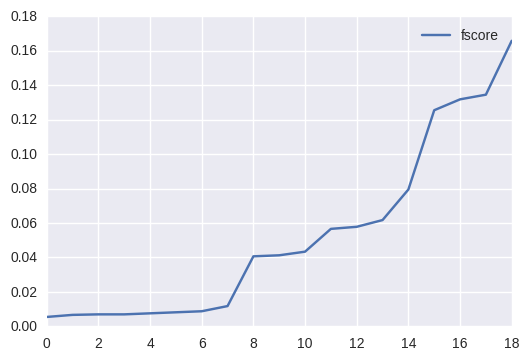

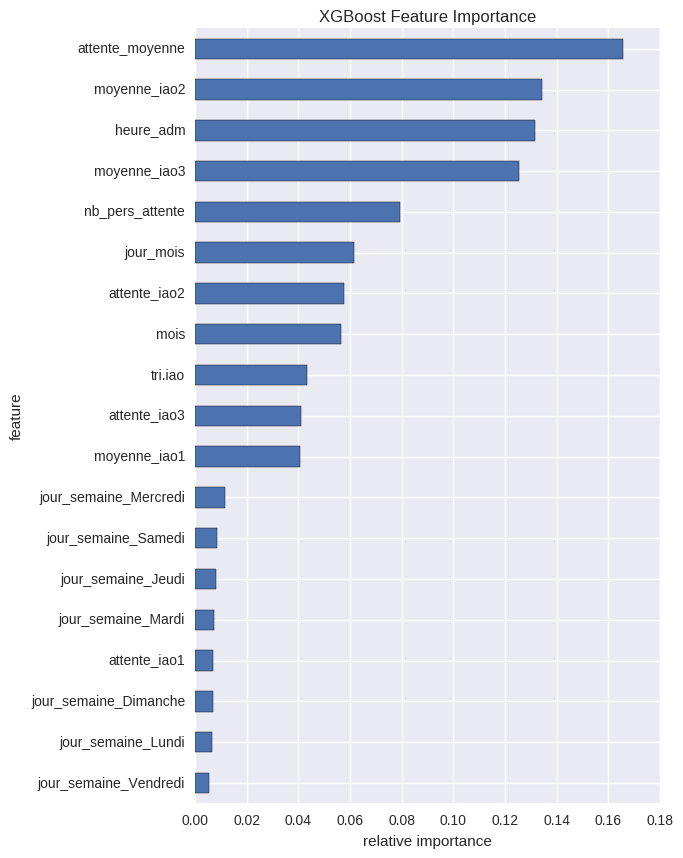

In [28]:
plt.figure()
df.iloc[-40:].plot()
df.iloc[-40:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [ ]:
base_glm = base
base_glm['tri.iao'] = base['tri.iao'].apply(str)
base_glm['mois'] = base['mois'].apply(str)
base_glm['tri.iao'] = base['tri.iao'].apply(str)
base_glm['annee'] = base['annee'].apply(str)
base_glm['heure_adm'] = base['heure_adm'].apply(str)

In [ ]:
X = base_glm[['tri.iao', 'nb_pers_attente', 'jour_mois', 'mois', 'annee']]
Y = base_glm['D.total']

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X) - Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X, Y))

In [ ]:
pd.DataFrame(list(zip(X.columns, regr.coef_)), columns = ['Variables', 'Coefficients'])

In [ ]:
X_train_glm = X_train_glm.drop('jour_semaine', axis = 1)
X_test_glm = X_test_glm.drop('jour_semaine', axis = 1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train_glm)
est = sm.GLM(y_train_glm, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
pred_glm = est2.predict(sm.add_constant(X_test_glm))
pred_moyenne = np.repeat(y_train_glm.mean(), len(y_test_glm), axis=0)
#Précision de notre modèle : 
metrics.mean_absolute_error(pred_moyenne, y_test_glm)

In [ ]:
metrics.mean_absolute_error(pred_glm, y_test_glm)


In [ ]:
metrics.mean_absolute_error(pred_moyenne, pred_moyenne + 30)

In [4]:
base_2013_2014 = pd.read_csv('./base_tot_finale.csv', sep = ',')

In [ ]:
base_2013_2014 = pd.read_csv('./base_tot_finale.csv', sep = ',')

In [5]:
var_input = pd.read_csv('/home/augustin/FlaskApp/input0.csv', sep = ',')
var_input['TS.adm'][0]
 



'2013-04-13 16:14:15'

In [6]:
base_2013_2014.head()

,TS.adm,tri.iao,D.total,jour_semaine,mois,annee,jour_mois,heure_adm,min_adm,TS.med,nb_pers_attente,attente_iao1,attente_iao2,attente_iao3,attente_moyenne,moyenne_iao1,moyenne_iao2,moyenne_iao3
0,2013-01-01 00:08:00,3,80,Mardi,1,2013,1,0,8,2013-01-01 01:28:00,0,0,0,0,-999.0,-999.0,-999.0,-999.0
1,2013-01-01 00:22:00,3,70,Mardi,1,2013,1,0,22,2013-01-01 01:32:00,1,0,0,1,-999.0,-999.0,-999.0,-999.0
2,2013-01-01 00:59:00,3,65,Mardi,1,2013,1,0,59,2013-01-01 02:04:00,2,0,0,2,-999.0,-999.0,-999.0,-999.0
3,2013-01-01 01:37:00,3,37,Mardi,1,2013,1,1,37,2013-01-01 02:14:00,1,0,0,1,75.0,-999.0,-999.0,75.0
4,2013-01-01 01:55:00,2,31,Mardi,1,2013,1,1,55,2013-01-01 02:26:00,2,0,0,2,75.0,-999.0,-999.0,75.0


In [9]:
from datetime import datetime
FMT = '%Y-%m-%d %H:%M:%S'
dates_list_adm = [datetime.strptime(date, FMT) for date in base_2013_2014['TS.adm']]
dates_list_med = [datetime.strptime(date, FMT) for date in base_2013_2014['TS.med']]

def compte_file_attente(dates_list_adm, dates_list_med, evt, vect_iao):
    vect_a_comparer = np.repeat(datetime.strptime(evt, FMT), len(dates_list_adm), axis=0)
    tmps_date_adm = pd.DataFrame(vect_a_comparer - dates_list_adm, columns=['diff'])
    tmps_date_med = pd.DataFrame(vect_a_comparer - dates_list_med, columns=['diff'])
    
    tmp1 = tmps_date_adm>0
    tmp1 = tmp1['diff']
    tmp2 = tmps_date_med<0
    tmp2 = tmp2['diff']
    tmp_iao_1 = vect_iao == 1
    tmp_iao_2 = vect_iao == 2
    tmp_iao_3 = vect_iao == 3
    
    indice_all = tmp1 & tmp2
    indice_iao_1 = indice_all & tmp_iao_1
    indice_iao_2 = indice_all & tmp_iao_2
    indice_iao_3 = indice_all & tmp_iao_3

    return([sum(indice_all.values),
    sum(indice_iao_1),
    sum(indice_iao_2),
    sum(indice_iao_3)])

In [281]:
def moyenne_file_attente_par_iao(dates_list_adm, dates_list_med, evt, vect_iao, fenetre_heure = 2, FMT = '%Y-%m-%d %H:%M:%S'):
# trier la base par date de ts.adm peut etre plus rapide
    vect_a_comparer = np.repeat(datetime.strptime(evt, FMT), len(dates_list_adm), axis=0)
    tmps_date_med = vect_a_comparer - dates_list_med
    tmp_base = [date.days*24 + date.seconds/3600  for date in tmps_date_med]
    base_tps_attente = [a - b for a, b in zip(dates_list_med, dates_list_adm)]
    attente_heure = [date.days*24 + date.seconds/3600  for date in base_tps_attente]
    
    tmp1 = pd.DataFrame(tmp_base, columns= ['diff']) < fenetre_heure 
    tmp2 = pd.DataFrame(tmp_base, columns= ['diff'])> 0
    tmp_iao_1 = vect_iao == 1
    tmp_iao_2 = vect_iao == 2
    tmp_iao_3 = vect_iao == 3
    
    indice_all = tmp1 & tmp2
    indice_all = indice_all['diff']
    indice_iao_1 = indice_all & tmp_iao_1
    indice_iao_2 = indice_all & tmp_iao_2
    indice_iao_3 = indice_all & tmp_iao_3

    
    df_attente = pd.DataFrame(attente_min, columns=['temps_attente'])
    return(np.mean(df_attente[indice_all]), np.mean(df_attente[indice_iao_1])
          , np.mean(df_attente[indice_iao_2]), np.mean(df_attente[indice_iao_3])) 
    
     


In [338]:
comptage = compte_file_attente(dates_list_adm, dates_list_med, var_input['TS.adm'][0], base_2013_2014['tri.iao'] )
moyenne = moyenne_file_attente_par_iao(dates_list_adm, dates_list_med, var_input['TS.adm'][0], base_2013_2014['tri.iao'])


var_tri_iao = var_input['tri.iao'][0]
moyenne_attente_all = moyenne[0][0]
moyenne_attente_iao1 = moyenne[1][0]
moyenne_attente_iao2 = moyenne[2][0]
moyenne_attente_iao3 = moyenne[3][0]
nb_attente_all = comptage[0]
nb_attente_iao1 = comptage[1]
nb_attente_iao2 = comptage[2]
nb_attente_iao3 = comptage[3]

pd.DataFrame([(var_tri_iao, moyenne_attente_all, moyenne_attente_iao1, moyenne_attente_iao2, moyenne_attente_iao3,
              nb_attente_all, nb_attente_iao1, nb_attente_iao2, nb_attente_iao3 )], 
             columns=['tri.iao', 'attente_moyenne', 'attente_moyenne_iao1', 'attente_moyenne_iao2',
                     'attente_moyenne_iao3', 'nb_pers_attente', 'nb_pers_attente_iao1', 'nb_pers_attente_iao2', 'nb_pers_attente_iao3'])

,tri.iao,attente_moyenne,attente_moyenne_iao1,attente_moyenne_iao2,attente_moyenne_iao3,nb_pers_attente,nb_pers_attente_iao1,nb_pers_attente_iao2,nb_pers_attente_iao3
0,3,48.416667,NaN,27.0,59.125,4,0,3,1


In [355]:
def Jour_semaine(date):
    if date.strftime('%w') == '0':
        result = 'Dimanche'
    elif date.strftime('%w') == '1':
        result = 'Lundi'
    elif date.strftime('%w') == '2':
        result = 'Mardi'
    elif date.strftime('%w') == '3':
        result = 'Mercredi'
    elif date.strftime('%w') == '4':
        result = 'Jeudi'
    elif date.strftime('%w') == '5':
        result = 'Vendredi'
    elif date.strftime('%w') == '6':
        result = 'Samedi'
    return result
    
mois = datetime.strptime(var_input['TS.adm'][0], FMT).strftime('%m')
jour_mois = datetime.strptime(var_input['TS.adm'][0], FMT).strftime('%d')
heure = datetime.strptime(var_input['TS.adm'][0], FMT).strftime('%H')
jour_semaine = Jour_semaine(datetime.strptime(var_input['TS.adm'][0], FMT))

In [1]:
import pandas as pd
import xgboost as xgb

prediction = pd.read_csv('/home/augustin/FlaskApp/input.csv', sep = ',')
model = xgb.Booster()
model.load_model('xgboost_hopital.model')
prediction = xgb.DMatrix(prediction)
prediction = model.predict(prediction)

/home/augustin/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd
prediction = pd.read_csv('/Users/noemiehaouzi/Desktop/ENSAE_3A/S2/Projet info/Git/projet-urgences/Codes Python/input.csv', sep = ',')


In [18]:
from flask import Flask, render_template
from flask import jsonify

json_file = [
    {
        'id':1,
        'prediction':str(20)
    },
    {
        'id':2,
        'prediction':str(21)
    }
]


app = Flask(__name__)
@app.route("/main")
def main():
	return jsonify(json_file)
if __name__ == "__main__":
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Apr/2017 11:17:33] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [21/Apr/2017 11:17:37] "GET /main HTTP/1.1" 200 -
127.0.0.1 - - [21/Apr/2017 11:17:37] "GET /main HTTP/1.1" 200 -


In [6]:
from flask import Flask, render_template
from flask import jsonify
from flask import request
import cgi
import cgitb; cgitb.enable() # Optional; for debugging only

from flask import jsonify

In [11]:
app = Flask(__name__)
@app.route("/main")
def main(): 
    app.debug = True
    TS = request.args.get('TS')
    print TS
    json_file = [
    {
        'id':1,
        'prediction_iao2':20,
        'prediction_iao3':40
    },
    {
        'id':2,
        'prediction_iao2':int(22),
        'prediction_iao3':47
    }
    ]

    return jsonify(json_file)

In [12]:
if __name__ == "__main__":
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Apr/2017 16:55:08] "GET /main HTTP/1.1" 500 -
Error on request:
Traceback (most recent call last):
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 180, in run_wsgi
    execute(self.server.app)
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 168, in execute
    application_iter = app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1836, in __call__
    return self.wsgi_app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1820, in wsgi_app
    response = self.make_response(self.handle_exception(e))
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1403, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1817, in wsgi_app
    response = self.full_dispatch_re

None


127.0.0.1 - - [21/Apr/2017 16:55:10] "GET /main HTTP/1.1" 500 -
Error on request:
Traceback (most recent call last):
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 180, in run_wsgi
    execute(self.server.app)
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 168, in execute
    application_iter = app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1836, in __call__
    return self.wsgi_app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1820, in wsgi_app
    response = self.make_response(self.handle_exception(e))
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1403, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1817, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/anaconda/lib/python2.7/site-packages/

None


127.0.0.1 - - [21/Apr/2017 16:55:15] "GET /main HTTP/1.1" 500 -
Error on request:
Traceback (most recent call last):
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 180, in run_wsgi
    execute(self.server.app)
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 168, in execute
    application_iter = app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1836, in __call__
    return self.wsgi_app(environ, start_response)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1820, in wsgi_app
    response = self.make_response(self.handle_exception(e))
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1403, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/anaconda/lib/python2.7/site-packages/flask/app.py", line 1817, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/anaconda/lib/python2.7/site-packages/

None
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 55605)
----------------------------------------


Traceback (most recent call last):
  File "/Users/anaconda/lib/python2.7/SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/anaconda/lib/python2.7/SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "/Users/anaconda/lib/python2.7/SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/anaconda/lib/python2.7/SocketServer.py", line 652, in __init__
    self.handle()
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 203, in handle
    rv = BaseHTTPRequestHandler.handle(self)
  File "/Users/anaconda/lib/python2.7/BaseHTTPServer.py", line 340, in handle
    self.handle_one_request()
  File "/Users/anaconda/lib/python2.7/site-packages/werkzeug/serving.py", line 234, in handle_one_request
    self.raw_requestline = self.rfile.readline()
  File "/Users/anaconda/lib/python2.7/socket.p